In [3]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import requests
import keras
import tensorflow
import tensorflow as tf
import pickle
model = pickle.load(open('model2.pkl','rb'))
import ee
import numpy as np
from skimage.transform import resize
from haversine import inverse_haversine, Direction

service_account = 'google-earth-engine@batch-883-povertymapper-352703.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'credentials.json')

# Initialize the library.
ee.Initialize(credentials)

In [4]:
def get_save_image(lat, lon, grid_size=4, s_date='2021-01-01', e_date= '2021-07-01', img_name='img_1', img_cat='img_cat'):

    lat = float(lat)
    lon = float(lon)
    grid_size = float(grid_size)

    start = ee.Date(s_date)
    finish = ee.Date(e_date)

    radius=(float(grid_size) * 2**0.5 )/2

    coord_ne = inverse_haversine((lat,lon), radius, Direction.NORTHEAST)
    coord_sw = inverse_haversine((lat,lon), radius, Direction.SOUTHWEST)

    pngRect = ee.Geometry.Rectangle([
                                    [coord_sw[1], coord_sw[0]],
                                    [coord_ne[1], coord_ne[0]]
                                    ])

    # print('Starting RGB Image Capture')

    # Import the Sentinel 2 ImageCollection
    daytime = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(pngRect)
            .filterDate(start, finish)
            .select(['TCI_R', 'TCI_G', 'TCI_B'])
            .sort('CLOUDY_PIXEL_PERCENTAGE', False)
            )

    daytime_img = daytime.mosaic().setDefaultProjection(daytime.first().projection())

    daytime_img_sample = daytime_img.sampleRectangle(pngRect)

    # Get individual band arrays.
    band_arr_TCI_R = daytime_img_sample.get('TCI_R')
    band_arr_TCI_G = daytime_img_sample.get('TCI_G')
    band_arr_TCI_B = daytime_img_sample.get('TCI_B')

    # Transfer the arrays from server to client and cast as np array.
    np_arr_TCI_R = np.array(band_arr_TCI_R.getInfo())
    np_arr_TCI_G = np.array(band_arr_TCI_G.getInfo())
    np_arr_TCI_B = np.array(band_arr_TCI_B.getInfo())

    # Expand the dimensions of the images so they can be concatenated into 3-D.
    np_arr_TCI_R = np.expand_dims(np_arr_TCI_R, 2)
    np_arr_TCI_G = np.expand_dims(np_arr_TCI_G, 2)
    np_arr_TCI_B = np.expand_dims(np_arr_TCI_B, 2)

    # Stack the individual bands to make a 3-D array.
    rgb_img = np.concatenate((np_arr_TCI_R, np_arr_TCI_G, np_arr_TCI_B), 2)

    rgb_img_256 = resize(rgb_img.astype(float),(256,256)).astype(np.uint8)

    # return rgb_img_256

    nighttime = (ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG')
                 .filterDate(start, finish)
                #  .filterBounds(pngRect)
                 .select('avg_rad')
                 )

    nighttime_img = nighttime.mosaic().setDefaultProjection(nighttime.first().projection())

    nighttime_img_sample = nighttime_img.sampleRectangle(
        pngRect,
        defaultValue=0
        )

    # Get individual band arrays.
    band_arr_avg_rad = nighttime_img_sample.get('avg_rad')

    # Transfer the arrays from server to client and cast as np array.
    np_arr_avg_rad = np.array(band_arr_avg_rad.getInfo())

    # Resize the array to 256x256
    rad_img_256 = resize(np_arr_avg_rad, (256, 256)).astype(np.uint8)

    # Expand the dimensions of the images so they can be concatenated into 3-D.
    rad_img_256 = np.expand_dims(rad_img_256, 2)

    # return rad_img_256

    feat_img = np.concatenate((rgb_img_256, rad_img_256), 2)

    return feat_img

In [30]:
lat = 19.07025
lon = 72.8366


new_model = tf.keras.models.load_model('mvp_model4')

# img = get_save_image(lat,lon)
# print(img.shape)
# print(type(img))



result = new_model.predict(np.expand_dims(img, 0))
result.argmax()+1

1/1 [==============================] - 0s 66ms/step


1

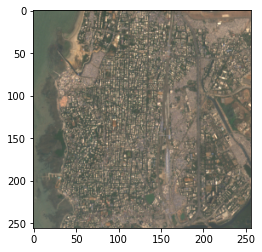

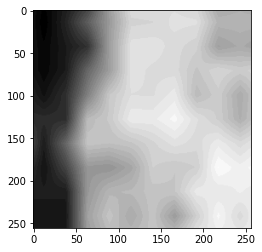

In [19]:
import matplotlib.pyplot as plt

plt.imshow(img[:,:,:3])
plt.show()
plt.imshow(img[:,:,-1:].reshape(256,256), cmap='gray')
plt.show()

In [23]:
img = img.reshape(256,256,4)

In [17]:
def get_save_image(lat, lon, grid_size=4, s_date='2021-01-01', e_date= '2021-07-01', img_name='img_1', img_cat='img_cat'):
    
    lat = float(lat)
    lon = float(lon)
    grid_size = float(grid_size)

    start = ee.Date(s_date)
    finish = ee.Date(e_date)

    radius=(float(grid_size) * 2**0.5 )/2

    coord_ne = inverse_haversine((lat,lon), radius, Direction.NORTHEAST)
    coord_sw = inverse_haversine((lat,lon), radius, Direction.SOUTHWEST)

    pngRect = ee.Geometry.Rectangle([
                                    [coord_sw[1], coord_sw[0]],
                                    [coord_ne[1], coord_ne[0]]
                                    ])

    print('Starting RGB Image Capture') 

    # Import the Sentinel 2 ImageCollection
    daytime = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(pngRect)
            .filterDate(start, finish)
            .select(['TCI_R', 'TCI_G', 'TCI_B'])
            .sort('CLOUDY_PIXEL_PERCENTAGE', False)
            )

    daytime_img = daytime.mosaic().setDefaultProjection(daytime.first().projection())

    daytime_img_sample = daytime_img.sampleRectangle(pngRect)

    # Get individual band arrays.
    band_arr_TCI_R = daytime_img_sample.get('TCI_R')
    band_arr_TCI_G = daytime_img_sample.get('TCI_G')
    band_arr_TCI_B = daytime_img_sample.get('TCI_B')

    # Transfer the arrays from server to client and cast as np array.
    np_arr_TCI_R = np.array(band_arr_TCI_R.getInfo())
    np_arr_TCI_G = np.array(band_arr_TCI_G.getInfo())
    np_arr_TCI_B = np.array(band_arr_TCI_B.getInfo())

    # Expand the dimensions of the images so they can be concatenated into 3-D.
    np_arr_TCI_R = np.expand_dims(np_arr_TCI_R, 2)
    np_arr_TCI_G = np.expand_dims(np_arr_TCI_G, 2)
    np_arr_TCI_B = np.expand_dims(np_arr_TCI_B, 2)

    # Stack the individual bands to make a 3-D array.
    rgb_img = np.concatenate((np_arr_TCI_R, np_arr_TCI_G, np_arr_TCI_B), 2)
    
    # Resize the image to 256x256. REMEMBER TO CHANGE THE INT64 FORMAT TO FLOAT IN
    # ORDER TO RESIZE!!!!!
    rgb_img_256 = resize(rgb_img.astype(float),(256,256)).astype(np.uint8)

    plt.imshow(rgb_img_256)
    plt.show()    
    
    print('Starting Radiance Image Capture')

    nighttime = (ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG')
                    .filterDate(start, finish)
                    # .filterBounds(pngRect)
                    .select('avg_rad')
                    )

    nighttime_img = nighttime.mosaic().setDefaultProjection(nighttime.first().projection())

    nighttime_img_sample = nighttime_img.sampleRectangle(
        pngRect,
        defaultValue=0
        )

    # Get individual band arrays.
    band_arr_avg_rad = nighttime_img_sample.get('avg_rad')

    # Transfer the arrays from server to client and cast as np array.
    np_arr_avg_rad = np.array(band_arr_avg_rad.getInfo())

    # Resize the array to 256x256
    rad_img_256 = resize(np_arr_avg_rad,(256,256)).astype(np.uint8)

    # Expand the dimensions of the images so they can be concatenated into 3-D.
    rad_img_256 = np.expand_dims(rad_img_256, 2)
    
    plt.imshow(rad_img_256, cmap='gray')
    plt.show()        

    # Stack the rgb and rad bands to make a feature array.

    feat_img = np.concatenate((rgb_img_256, rad_img_256), 2)
    print(f'feat_img Dimensions: {str(feat_img.shape)}')
    print(f'feat_img Type: {str(type(feat_img))}')
    
    return feat_img

    # file_path = '/content/drive/MyDrive/'+str(img_cat)
    # np.save(file_path+'/'+str(img_name)+'.npy', feat_img)
    # print(str(img_name)+'.npy Saved!')


Starting RGB Image Capture


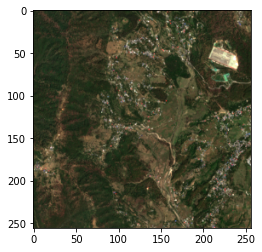

Starting Radiance Image Capture


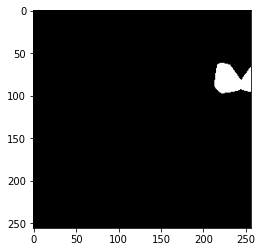

feat_img Dimensions: (256, 256, 4)
feat_img Type: <class 'numpy.ndarray'>


In [15]:
get_save_image(lat,lon)